In [0]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train.csv
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test.csv

In [0]:
!mkdir data
!mkdir data/test
!mkdir data/train
!unzip train_images -d data/train
!unzip test_images -d data/test

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train_images/145896eed0.jpg  
  inflating: data/train/train_images/c468193dfd.jpg  
  inflating: data/train/train_images/7c6dccda37.jpg  
  inflating: data/train/train_images/c03811cd27.jpg  
  inflating: data/train/train_images/f04e23613b.jpg  
  inflating: data/train/train_images/d1cbbc1134.jpg  
  inflating: data/train/train_images/d762ff4fd3.jpg  
  inflating: data/train/train_images/1df8826db5.jpg  
  inflating: data/train/train_images/4f05c60d04.jpg  
  inflating: data/train/train_images/1b33d95837.jpg  
  inflating: data/train/train_images/fa3e225fe7.jpg  
  inflating: data/train/train_images/7bcd015a19.jpg  
  inflating: data/train/train_images/a413778c2b.jpg  
  inflating: data/train/train_images/4945972217.jpg  
  inflating: data/train/train_images/5245cffff8.jpg  
  inflating: data/train/train_images/6012b508f4.jpg  
  inflating: data/train/train_images/8bf820b404.jpg  
  inflating: data/train/train_i

In [0]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense,Conv2D, Dropout, MaxPooling2D, Flatten, BatchNormalization, Activation, ReLU, Input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, DenseNet169, DenseNet201
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
from random import seed, shuffle
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral)
from learningratefinder import LearningRateFinder
import cv2
import shutil

from mixup_generator import MixupGenerator
from albumentations import (HorizontalFlip, Blur, VerticalFlip, Transpose, RandomCrop, 
                            RandomGamma, ShiftScaleRotate,
                            HueSaturationValue, RGBShift, RandomBrightness, RandomContrast, CLAHE) 
%matplotlib inline

In [0]:
df = pd.read_csv('train.csv')
print(len(df))
df.head()

9323


,ImageId,ClassName
0,f27632d7e5.jpg,water
1,efa87919ed.jpg,pizza-margherita-baked
2,4f169e8c8d.jpg,broccoli
3,a6956654bf.jpg,salad-leaf-salad-green
4,d99ce8c3bf.jpg,egg


In [0]:
unique, counts = np.unique(df["ClassName"], return_counts=True)
class_count_dict = dict(zip(unique, counts))

In [0]:
class_names = df['ClassName']
class_names = (np.unique(class_names))
class_names

array(['almonds', 'apple', 'avocado', 'banana', 'beer', 'biscuits',
       'boisson-au-glucose-50g', 'bread-french-white-flour',
       'bread-sourdough', 'bread-white', 'bread-whole-wheat',
       'bread-wholemeal', 'broccoli', 'butter', 'carrot', 'cheese',
       'chicken', 'chips-french-fries', 'coffee-with-caffeine', 'corn',
       'croissant', 'cucumber', 'dark-chocolate', 'egg',
       'espresso-with-caffeine', 'french-beans', 'gruyere', 'ham-raw',
       'hard-cheese', 'honey', 'jam', 'leaf-spinach', 'mandarine',
       'mayonnaise', 'mixed-nuts', 'mixed-salad-chopped-without-sauce',
       'mixed-vegetables', 'onion', 'parmesan', 'pasta-spaghetti',
       'pickle', 'pizza-margherita-baked', 'potatoes-steamed', 'rice',
       'salad-leaf-salad-green', 'salami', 'salmon', 'sauce-savoury',
       'soft-cheese', 'strawberries', 'sweet-pepper', 'tea', 'tea-green',
       'tomato', 'tomato-sauce', 'water', 'water-mineral',
       'white-coffee-with-caffeine', 'wine-red', 'wine-white'

In [0]:
le = LabelEncoder()
le.fit(df['ClassName'])
encoded_class_names = le.transform(df['ClassName'])
len(encoded_class_names)

9323

In [0]:
unique, counts = np.unique(encoded_class_names, return_counts=True)
class_count_encoded = dict(zip(unique, counts))
class_count_encoded

{0: 69,
 1: 191,
 2: 88,
 3: 181,
 4: 80,
 5: 68,
 6: 85,
 7: 61,
 8: 63,
 9: 595,
 10: 74,
 11: 398,
 12: 84,
 13: 346,
 14: 297,
 15: 137,
 16: 106,
 17: 136,
 18: 377,
 19: 37,
 20: 75,
 21: 107,
 22: 88,
 23: 209,
 24: 195,
 25: 75,
 26: 71,
 27: 66,
 28: 112,
 29: 65,
 30: 163,
 31: 87,
 32: 69,
 33: 43,
 34: 81,
 35: 169,
 36: 237,
 37: 41,
 38: 68,
 39: 97,
 40: 28,
 41: 110,
 42: 156,
 43: 256,
 44: 535,
 45: 49,
 46: 51,
 47: 61,
 48: 48,
 49: 87,
 50: 84,
 51: 177,
 52: 69,
 53: 358,
 54: 110,
 55: 863,
 56: 86,
 57: 122,
 58: 241,
 59: 151,
 60: 90}

# Utility Functions

In [0]:
def plot_LR(model, batch_size, x_train, y_train, aug, class_weight=None):
  lrf = LearningRateFinder(model)
  lrf.find(aug.flow(x_train, y_train, batch_size=batch_size),
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil((len(x_train) / batch_size)),
    batchSize=batch_size)
 
  lrf.plot_loss()

In [0]:
#defining the model
def get_base_model(shape=(224, 224, 3), weights = None, get_only_base = False):

  if(get_only_base):

    model = DenseNet121(include_top = False, weights = weights, 
                            input_tensor=Input(shape=shape))

  else:
    base_model = DenseNet121(include_top = False, weights = weights, 
                            input_tensor=Input(shape=shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.3)(x)
    #x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.25)(x)
    preds = Dense(61, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01), 
                  activity_regularizer=regularizers.l2(0.01))(x)

    model = Model(inputs = base_model.inputs, outputs = preds)

  return model


In [0]:
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Train vs Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Train vs Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

# Numpy Approach


In [0]:
def augment(aug, image):
    aug_image = aug(image=image)['image']
    #plt.imsave(save_path, image, format = 'jpg')

    return aug_image

In [0]:
transforms = le.transform(list(class_count_dict.keys()))
transforms

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [0]:
minority_encoded1=[]
minority_encoded2=[]
for key in class_count_encoded.keys():
  if(class_count_encoded[key]<100):
    minority_encoded1.append(key)
  elif(class_count_encoded[key]>100 and class_count_encoded[key]<200):
    minority_encoded2.append(key)

np.array(minority_encoded1), np.array(minority_encoded2)

(array([ 0,  2,  4,  5,  6,  7,  8, 10, 12, 19, 20, 22, 25, 26, 27, 29, 31,
        32, 33, 34, 37, 38, 39, 40, 45, 46, 47, 48, 49, 50, 52, 56, 60]),
 array([ 1,  3, 15, 16, 17, 21, 24, 28, 30, 35, 41, 42, 51, 54, 57, 59]))

In [0]:
set(minority_encoded1).intersection(minority_encoded2)

set()

In [0]:
def create_numpy_data(df,minority_encoded1,minority_encoded2,shape=(128,128)):
  ids = np.array(df['ImageId'])
  classes = encoded_class_names
  DATA = []
  LABELS = []
  directory = 'data/train/train_images/'

  for i in range(len(ids)):
    ID = ids[i]
    class_name = classes[i]
    img = cv2.imread(directory+ID)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = cv2.resize(img, shape)
    #Augment here
    if(class_name in minority_encoded1):
      print("MINORITY CLASS 1")
      print("="*100)
      augmented_img1 = augment(HueSaturationValue(p=1), img_)
      augmented_img1 = augment(RGBShift(p=1, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10), augmented_img1)

      augmented_img2 = augment(RGBShift(p=1, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10), img_)
      augmented_img2 = augment(CLAHE(p=1), augmented_img2)

      augmented_img3 = augment(CLAHE(p=1), img_)
      augmented_img3 = augment(RandomBrightness(p=1), augmented_img3)

      augmented_img4 = augment(RandomBrightness(p=1),img_)
      augmented_img4 = augment(Transpose(p=1), augmented_img4)

      augmented_img5 = augment(RandomContrast(p=1), img_)
      augmented_img5 = augment(ShiftScaleRotate(p=1), augmented_img5)

      DATA.append(np.array(augmented_img1))
      DATA.append(np.array(augmented_img2))
      DATA.append(np.array(augmented_img3))
      DATA.append(np.array(augmented_img4))
      DATA.append(np.array(augmented_img5))
      LABELS.append(np.array(class_name))
      LABELS.append(np.array(class_name))
      LABELS.append(np.array(class_name))
      LABELS.append(np.array(class_name))
      LABELS.append(np.array(class_name))
      #print(ID, class_name)

    elif(class_name in minority_encoded2):
      print("MINORITY CLASS 2")
      print("="*100)
      augmented_img1 = augment(HueSaturationValue(p=1), img_)
      augmented_img1 = augment(RGBShift(p=1, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10), augmented_img1)

      augmented_img2 = augment(ShiftScaleRotate(p=1), img_)
      augmented_img2 = augment(CLAHE(p=1), augmented_img2)

      DATA.append(np.array(augmented_img1))
      DATA.append(np.array(augmented_img2))
      LABELS.append(np.array(class_name))
      LABELS.append(np.array(class_name))
      #print(ID, class_name)
  
    else:   
      DATA.append(img_)
      LABELS.append(np.array(class_name))
    #print(ID, class_name)

  return DATA, LABELS

In [0]:
DATA, LABELS = create_numpy_data(df,minority_encoded1,minority_encoded2,(150, 150))

In [0]:
unique, counts = np.unique(LABELS, return_counts=True)
class_count_aug = dict(zip(unique, counts))


In [0]:
for val1, val2 in zip(list(class_count_encoded.values()), list(class_count_aug.values())):
  print(val1, val2)

In [0]:
for key in list(class_count_encoded.keys()):
  if(class_count_aug[key]<200):
    print(key)

19
40


In [0]:
class_count_aug[19], class_count_aug[40]

(185, 140)

In [0]:
#Augmenting class 40 and 19 further
shape = (150,150)
ids = np.array(df['ImageId'])
classes = encoded_class_names
directory = 'data/train/train_images/'

for i in range(len(ids)):
  ID = ids[i]
  class_name = classes[i]

  #Augment here
  if(class_name == 40):
    
    img = cv2.imread(directory+ID)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = cv2.resize(img, shape)

    aug1 = augment(HorizontalFlip(p=1), img_)
    aug1 = augment(ShiftScaleRotate(p=1), aug1)

    aug2 = augment(ShiftScaleRotate(p=1), img_)
    aug2 = augment(HorizontalFlip(p=1), aug2)

    aug3 = augment(Transpose(p=1), img_)
    aug3 = augment(CLAHE(p=1), aug3)
  

    DATA.append(np.array(aug1))
    DATA.append(np.array(aug2))
    DATA.append(np.array(aug3))
    LABELS.append(np.array(class_name))
    LABELS.append(np.array(class_name))
    LABELS.append(np.array(class_name))

  elif(class_name == 19):
    
    img = cv2.imread(directory+ID)
    img_ = cv2.resize(img, shape)

    aug1 = augment(HorizontalFlip(p=1), img_)
    aug1 = augment(ShiftScaleRotate(p=1), aug1)

    aug2 = augment(ShiftScaleRotate(p=1), img_)
    aug2 = augment(HorizontalFlip(p=1), aug2)
    
    DATA.append(np.array(aug1))
    DATA.append(np.array(aug2))
    LABELS.append(np.array(class_name))
    LABELS.append(np.array(class_name))


In [0]:
unique, counts = np.unique(LABELS, return_counts=True)
class_count_aug = dict(zip(unique, counts))


In [0]:
np.median(list(class_count_aug.values()))

340.0

In [0]:
np.array(DATA).shape, np.array(LABELS).shape
#((9323, 128, 128, 3), (9323,))

((20798, 150, 150, 3), (20798,))

In [0]:
#Normalize the arrays
DATA = np.array(DATA)
DATA.astype('float32')
DATA = preprocess_input(DATA)

In [0]:
LABELS = to_categorical(np.array(LABELS), 61)
LABELS.shape

(20798, 61)

In [0]:
#CLASS_WEIGHT
class_weight = {}
for i in list(class_count_aug.keys()):
  
  total = np.sum(list(class_count_aug.values()))
  val = class_count_aug[i]
  new_val = int(total/val)

  if(i in low_f1_encoded):
    new_val = int(np.round(new_val/10))
  else:
    new_val = 1
  
  class_weight[i] = new_val

In [0]:
class_weight

In [0]:
x_train, x_val, y_train, y_val = train_test_split(DATA, LABELS, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(16638, 150, 150, 3) (16638, 61) (4160, 150, 150, 3) (4160, 61)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(14974, 150, 150, 3) (14974, 61) (1664, 150, 150, 3) (1664, 61)


In [0]:
aug = ImageDataGenerator(rotation_range=40,
                         zoom_range=0.35,
                         width_shift_range=0.4,
                         height_shift_range=0.4,
                         shear_range=0.30,
                         horizontal_flip=True,
                         vertical_flip = False,
                         fill_mode='nearest'
                         )

In [0]:
generator2 = MixupGenerator(x_train, y_train, alpha=1.0, datagen=aug)()

In [0]:
'''base_model = get_base_model(shape=(150,150,3), weights = 'imagenet', get_only_base=True)

set_trainable = False
for layer in base_model.layers:
  if layer.name == 'conv5_block16_0_bn':
    set_trainable = True
  if(set_trainable):
    layer.trainable = True
  else:
    layer.trainable = False'''

29089792/29084464 [==============================] - 1s 0us/step


In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(61, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01), 
              activity_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs = base_model.inputs, outputs = preds)

In [0]:
opt = Adam(decay=1e-3/70)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
np.ceil((len(x_train) / float(64)))

236.0

In [0]:
lrf = LearningRateFinder(model)
lrf.find(
		aug.flow(x_train, y_train, batch_size=64),
		1e-6, 1e+2,
		stepsPerEpoch=1000,
		batchSize=64)


Epoch 1/3
1000/1000 [==============================] - 286s 286ms/step - loss: 8.3088 - accuracy: 0.0168
Epoch 2/3
1000/1000 [==============================] - 289s 289ms/step - loss: 6.8115 - accuracy: 0.1612
Epoch 3/3
1000/1000 [==============================] - 292s 292ms/step - loss: 37.3179 - accuracy: 0.1954


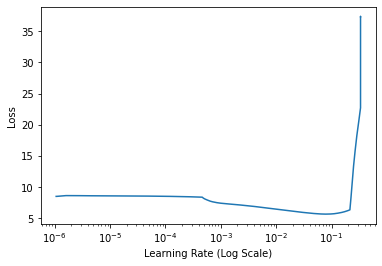

In [0]:
lrf.plot_loss()


## Training the Model

In [0]:
'''base_model = get_base_model(shape=(150,150,3), weights = 'imagenet', get_only_base=True)
'''for layer in model.layers[:20]:
  layer.trainable = False'''
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(61, activation = 'softmax', kernel_regularizer=regularizers.l2(0.01), 
              activity_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs = base_model.inputs, outputs = preds)'''

In [0]:

eff_net = EfficientNetB3(weights='imagenet', input_tensor=Input(shape=(150, 150, 3)), include_top=False)

set_trainable = False

for layer in eff_net.layers:
  if layer.name in ['block7a_expand_conv','block7b_expand_conv']:
    set_trainable = True
  if(set_trainable):
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
model = Sequential()
model.add(eff_net)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(61, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
checkpoints_path = 'EffNet-balanced_data-mixup.h5'
mc = ModelCheckpoint(filepath = checkpoints_path, monitor='val_accuracy', verbose=1, 
                     save_best_only=True, save_weights_only=False, mode='max', period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=8, min_lr=1e-5, verbose = 1, min_delta=0.1)

#opt = SGD(lr = 1e-2, decay=1e-2/100)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit_generator(generator=generator2,
	validation_data=(x_val, y_val), steps_per_epoch=x_train.shape[0] // 64,
	epochs=100, verbose=1, callbacks=[mc, reduce_lr])

Epoch 1/100
233/233 [==============================] - ETA: 0s - loss: 3.6522 - accuracy: 0.1529
Epoch 00001: val_accuracy improved from -inf to 0.35577, saving model to EffNet-balanced_data-mixup.h5
233/233 [==============================] - 56s 240ms/step - loss: 3.6522 - accuracy: 0.1529 - val_loss: 2.3720 - val_accuracy: 0.3558 - lr: 0.0010
Epoch 2/100
233/233 [==============================] - ETA: 0s - loss: 3.2583 - accuracy: 0.2617
Epoch 00002: val_accuracy improved from 0.35577 to 0.42188, saving model to EffNet-balanced_data-mixup.h5
233/233 [==============================] - 53s 229ms/step - loss: 3.2583 - accuracy: 0.2617 - val_loss: 2.0648 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 3/100
233/233 [==============================] - ETA: 0s - loss: 3.1423 - accuracy: 0.3004
Epoch 00003: val_accuracy improved from 0.42188 to 0.45288, saving model to EffNet-balanced_data-mixup.h5
233/233 [==============================] - 53s 229ms/step - loss: 3.1423 - accuracy: 0.3004 - val_lo

In [0]:
best_model = load_model('EffNet-balanced_data-mixup.h5')

In [0]:
plot_acc(history)

In [0]:
plot_loss(history)

In [0]:
#Predictions
df_test = pd.read_csv('test.csv')
test_IDs = df_test['ImageId']


In [0]:
score = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

52/52 [==============================] - 2s 39ms/step - loss: 1.0529 - accuracy: 0.7169
Test loss: 1.0529003143310547
Test accuracy: 0.7169471383094788


In [0]:
parent = 'data/test/test_images/'
predictions=[]
TEST_DATA = []
count = 0
for ID in test_IDs:
  count+=1
  img = cv2.imread(parent+ID)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_ = cv2.resize(img, (150,150))
  TEST_DATA.append(img_)
  #img_ = np.expand_dims(img_, axis = 0)
  #pred = best_model.predict(img_)
  #print(pred)
  #pred_class = np.argmax(pred)
  #print(pred_class)
  #predictions.append(np.argmax(pred))


In [0]:
import os
len(os.listdir('/content/data/test/test_images/'))

484

In [0]:
TEST_DATA = np.array(TEST_DATA)
TEST_DATA.astype('float32')
TEST_DATA = preprocess_input(TEST_DATA)

In [0]:
len(TEST_DATA)

484

In [0]:
for i in range(len(TEST_DATA)):
  img = TEST_DATA[i]
  img = np.expand_dims(img, axis = 0)
  pred = best_model.predict(img)
  pred_class = np.argmax(pred)
  predictions.append(np.argmax(pred))

In [0]:
predictions = le.inverse_transform(predictions)
np.array(predictions)

array(['water', 'water', 'coffee-with-caffeine', 'hard-cheese',
       'bread-wholemeal', 'coffee-with-caffeine', 'almonds',
       'bread-sourdough', 'water', 'coffee-with-caffeine',
       'coffee-with-caffeine', 'water', 'banana', 'bread-white',
       'coffee-with-caffeine', 'salami', 'boisson-au-glucose-50g',
       'pasta-spaghetti', 'pasta-spaghetti', 'leaf-spinach',
       'bread-white', 'carrot', 'carrot', 'bread-wholemeal', 'water',
       'water', 'wine-red', 'mandarine', 'cucumber', 'tea', 'broccoli',
       'potatoes-steamed', 'mixed-vegetables', 'water', 'gruyere',
       'bread-white', 'coffee-with-caffeine', 'water', 'almonds',
       'mixed-vegetables', 'pizza-margherita-baked',
       'coffee-with-caffeine', 'tea-green', 'bread-french-white-flour',
       'coffee-with-caffeine', 'bread-whole-wheat', 'bread-white',
       'chips-french-fries', 'salad-leaf-salad-green', 'bread-wholemeal',
       'hard-cheese', 'carrot', 'coffee-with-caffeine', 'wine-white',
       'mixe

In [0]:
submission = pd.DataFrame(predictions,columns=['ClassName'])
submission.to_csv('sub-effnet-mixup.csv', index=False)

In [0]:
class_count_aug

### Testing Predictions

In [0]:
best_model = load_model('Densenet-balanced_data.h5')

In [0]:
score = best_model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
#Getting Predictions
y_pred = []
y_true = []
for i in range(len(y_val)):
  img = np.expand_dims(x_val[i], axis=0)
  prediction = best_model.predict(img)

  y_pred.append(np.argmax(prediction))
  y_true.append(np.argmax(y_val[i]))

In [0]:
from sklearn.metrics import classification_report
report = classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), output_dict=True)
report.pop('accuracy')

0.6724713740458015

In [0]:
report.pop('macro avg')
report.pop('weighted avg')
report_keys_encoded = le.transform(list(report.keys()))

In [0]:
low_f1_classes = []
f1_dict = {}
max_f1 = 0
for class_ in report_keys_encoded:
  decoded_class = le.inverse_transform([class_])[0]
  f1 = report[decoded_class]['f1-score']
  f1_dict[class_] = f1
  
  if(f1 < 0.6):
    low_f1_classes.append(class_)
    low_f1.append(f1)

In [0]:
low_f1_classes

In [0]:
low_f1_encoded = le.transform(low_f1_classes)
low_f1_encoded

array([ 7,  8,  9, 10, 11, 13, 14, 15, 16, 21, 26, 28, 30, 33, 35, 36, 37,
       42, 43, 46, 47, 50, 51, 53, 54, 57])

In [0]:
f1_dict

In [0]:
np.amax(list(f1_dict.values()))

0.9462365591397849

In [0]:
#CLASS_WEIGHT
class_weight_new = {}
for i in list(f1_dict.keys()):
  
  max_f1 = np.amax(list(f1_dict.values()))

  val = f1_dict[i]
  #new_val = int(max_f1/val)

  if(i in low_f1_encoded):
    print('In low')
    #new_val = int(np.round(new_val/10))
    new_val = (max_f1/val)
    print(new_val)
  else:
    print('In normal')
    new_val = 1
    print(new_val)
  
  class_weight_new[i] = new_val

In [0]:
class_weight_new

# Progressive Training

# Plotting the size of different Images

In [0]:
!pip install efficientnet

In [0]:
from efficientnet.tfkeras import EfficientNetB3, EfficientNetB7
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


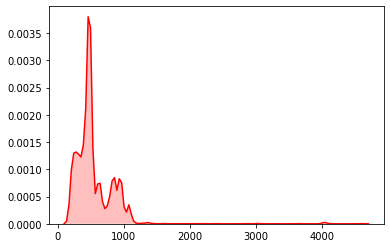

In [0]:
directory = 'data/train/train_images/'
ids = np.array(df['ImageId'])
w = []
h = []
for i in range(len(ids)):
  ID = ids[i]
  img = cv2.imread(directory+ID)
  h.append(img.shape[0])
  w.append(img.shape[1])

ax = sns.kdeplot(h,shade=True, color="r")

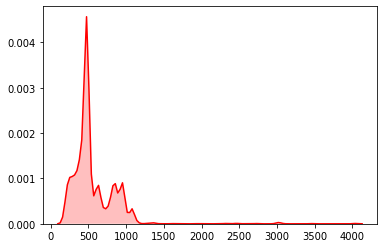

In [0]:
ax = sns.kdeplot(w,shade=True, color="r")

In [0]:
#Width peaks around 500
#Height peaks around 500

## 48 X 48

In [0]:
shape = (48, 48)
model_shape = (48, 48, 3)

In [0]:
DATA, LABELS = create_numpy_data(df,minority_encoded1,minority_encoded2,shape=shape)

In [0]:
#Normalize the arrays
DATA = np.array(DATA)
DATA.astype('float32')
DATA = preprocess_input(DATA)

LABELS = to_categorical(np.array(LABELS), 61)
LABELS.shape

(20798, 61)

In [0]:
DATA.shape

(20798, 48, 48, 3)

In [0]:
x_train, x_val, y_train, y_val = train_test_split(DATA, LABELS, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(16638, 48, 48, 3) (16638, 61) (4160, 48, 48, 3) (4160, 61)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(14974, 48, 48, 3) (14974, 61) (1664, 48, 48, 3) (1664, 61)


In [0]:
aug = ImageDataGenerator(rotation_range=40,
                         zoom_range=0.35,
                         width_shift_range=0.4,
                         height_shift_range=0.4,
                         shear_range=0.30,
                         horizontal_flip=True,
                         vertical_flip = False,
                         fill_mode='nearest'
                         )
generator2 = MixupGenerator(x_train, y_train, alpha=1.0, datagen=aug)()

In [0]:
checkpoints_path = 'EffNet-Progressive-Mixup.h5'
mc = ModelCheckpoint(filepath = checkpoints_path, monitor='val_loss', verbose=1, 
                     save_best_only=True, save_weights_only=False, mode='auto', period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-4, verbose = 1, min_delta=0.1)

In [0]:
eff_net = EfficientNetB3(weights='imagenet', input_tensor=Input(shape=model_shape), include_top=False)
#eff_net.summary()

In [0]:
set_trainable = False

for layer in eff_net.layers:
  if layer.name in ['block7a_expand_conv','block7b_expand_conv']:
    set_trainable = True
  if(set_trainable):
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
model = Sequential()
model.add(eff_net)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(61, activation='sigmoid'))

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit_generator(generator=generator2,
	validation_data=(x_val, y_val), steps_per_epoch=x_train.shape[0] // 64,
	epochs=50, verbose=1, callbacks=[mc, reduce_lr])

Epoch 1/50
232/233 [============================>.] - ETA: 0s - loss: 3.8904 - accuracy: 0.1001
Epoch 00001: val_loss improved from inf to 3.52817, saving model to EffNet-Progressive-Mixup.h5
233/233 [==============================] - 14s 60ms/step - loss: 3.8892 - accuracy: 0.0999 - val_loss: 3.5282 - val_accuracy: 0.1776 - lr: 0.0010
Epoch 2/50
233/233 [==============================] - ETA: 0s - loss: 3.6492 - accuracy: 0.1497
Epoch 00002: val_loss improved from 3.52817 to 3.15929, saving model to EffNet-Progressive-Mixup.h5
233/233 [==============================] - 12s 50ms/step - loss: 3.6492 - accuracy: 0.1497 - val_loss: 3.1593 - val_accuracy: 0.2209 - lr: 0.0010
Epoch 3/50
232/233 [============================>.] - ETA: 0s - loss: 3.5928 - accuracy: 0.1550
Epoch 00003: val_loss improved from 3.15929 to 2.89093, saving model to EffNet-Progressive-Mixup.h5
233/233 [==============================] - 12s 50ms/step - loss: 3.5917 - accuracy: 0.1553 - val_loss: 2.8909 - val_accuracy

## 96X96

In [0]:
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
model2.add(Conv2D(64, kernel_size=(3, 3), input_shape=(96, 96, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_48 = load_model('EffNet-Progressive-Mixup-48.h5')

In [0]:
for layer in model_48.layers[0].layers[2:]:
  model2.add(layer)
  #print(layer.name)

In [0]:
model_48.layers